In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [3]:
# Selected columns
program_cols = [
    'UNITID', 'INSTNM', 'CIPCODE', 'CIPDESC', 'CREDLEV', 'CREDDESC',
    'EARN_MDN_4YR', 'EARN_MDN_1YR', 'EARN_COUNT_WNE_4YR', 'EARN_COUNT_WNE_1YR',
    'DISTANCE'
]

institution_cols = [
    'UNITID', 'MD_EARN_WNE_P10', 'STABBR', 'REGION', 'CONTROL',
    'COSTT4_A', 'TUITIONFEE_IN', 'C150_4', 'ADM_RATE', 'PCTPELL'
]

# Load programs
df_programs = pd.read_csv(
    '/content/drive/MyDrive/5450_Files/Most-Recent-Cohorts-Field-of-Study.csv',
    usecols=program_cols,
    low_memory=False
)
print(f"Programs loaded: {len(df_programs):,}")

# Load institutions
df_institutions = pd.read_csv(
    '/content/drive/MyDrive/5450_Files/Most-Recent-Cohorts-Institution.csv',
    usecols=institution_cols,
    low_memory=False
).drop_duplicates(subset='UNITID')
print(f"Institutions loaded: {len(df_institutions):,}")

Programs loaded: 229,188
Institutions loaded: 6,429


In [4]:
# Merge programs + institutions
merged_df = df_programs.merge(df_institutions, on='UNITID', how='left')
print(f"Merged dataset: {len(merged_df):,} rows, {merged_df.shape[1]} columns")

# Clean up memory
del df_programs, df_institutions
gc.collect()

Merged dataset: 229,188 rows, 20 columns


0

In [5]:
print("\nCleaning privacy-suppressed values...")

# Replace PS/PrivacySuppressed with NaN
merged_df = merged_df.replace(['PrivacySuppressed', 'PS', 'NULL', 'null'], np.nan)

print("Privacy-suppressed values cleaned up to NaN")



Cleaning privacy-suppressed values...
Privacy-suppressed values cleaned up to NaN


In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229188 entries, 0 to 229187
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   UNITID              219079 non-null  float64
 1   INSTNM              229188 non-null  object 
 2   CIPCODE             229188 non-null  int64  
 3   CIPDESC             229188 non-null  object 
 4   CREDLEV             229188 non-null  int64  
 5   CREDDESC            229188 non-null  object 
 6   EARN_COUNT_WNE_1YR  52005 non-null   object 
 7   EARN_MDN_1YR        52005 non-null   object 
 8   EARN_COUNT_WNE_4YR  50721 non-null   object 
 9   EARN_MDN_4YR        50721 non-null   object 
 10  DISTANCE            229188 non-null  int64  
 11  STABBR              213711 non-null  object 
 12  CONTROL             213711 non-null  float64
 13  REGION              213711 non-null  float64
 14  ADM_RATE            129523 non-null  float64
 15  COSTT4_A            198820 non-nul

In [7]:
print("\nConverting columns to numeric...")

# Get numeric columns (exclude text columns)
numeric_cols = [col for col in merged_df.columns
                if col not in ['INSTNM', 'CIPDESC', 'CREDDESC', 'STABBR']]

# Convert
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

print(f"Converted {len(numeric_cols)} columns to numeric")


Converting columns to numeric...
Converted 16 columns to numeric


In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229188 entries, 0 to 229187
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   UNITID              219079 non-null  float64
 1   INSTNM              229188 non-null  object 
 2   CIPCODE             229188 non-null  int64  
 3   CIPDESC             229188 non-null  object 
 4   CREDLEV             229188 non-null  int64  
 5   CREDDESC            229188 non-null  object 
 6   EARN_COUNT_WNE_1YR  52005 non-null   float64
 7   EARN_MDN_1YR        52005 non-null   float64
 8   EARN_COUNT_WNE_4YR  50721 non-null   float64
 9   EARN_MDN_4YR        50721 non-null   float64
 10  DISTANCE            229188 non-null  int64  
 11  STABBR              213711 non-null  object 
 12  CONTROL             213711 non-null  float64
 13  REGION              213711 non-null  float64
 14  ADM_RATE            129523 non-null  float64
 15  COSTT4_A            198820 non-nul

In [9]:
merged_df_nops = merged_df.copy()  # "nops" = no privacy suppressed

print(f"\n Cleaned dataset ready: {merged_df_nops.shape}")
print(f"  Rows: {len(merged_df_nops):,}")
print(f"  Columns: {merged_df_nops.shape[1]}")


 Cleaned dataset ready: (229188, 20)
  Rows: 229,188
  Columns: 20


In [10]:
print("\nData types:")
print(merged_df_nops.dtypes)


Data types:
UNITID                float64
INSTNM                 object
CIPCODE                 int64
CIPDESC                object
CREDLEV                 int64
CREDDESC               object
EARN_COUNT_WNE_1YR    float64
EARN_MDN_1YR          float64
EARN_COUNT_WNE_4YR    float64
EARN_MDN_4YR          float64
DISTANCE                int64
STABBR                 object
CONTROL               float64
REGION                float64
ADM_RATE              float64
COSTT4_A              float64
TUITIONFEE_IN         float64
PCTPELL               float64
C150_4                float64
MD_EARN_WNE_P10       float64
dtype: object


In [11]:
print("\nMissing data summary:")
missing = merged_df_nops.isnull().sum()
missing_pct = (missing / len(merged_df_nops) * 100).round(1)

for col in merged_df_nops.columns:
    if missing[col] > 0:
        print(f"  {col:25s}: {missing[col]:,} ({missing_pct[col]}%)")


Missing data summary:
  UNITID                   : 10,109 (4.4%)
  EARN_COUNT_WNE_1YR       : 177,183 (77.3%)
  EARN_MDN_1YR             : 177,183 (77.3%)
  EARN_COUNT_WNE_4YR       : 178,467 (77.9%)
  EARN_MDN_4YR             : 178,467 (77.9%)
  STABBR                   : 15,477 (6.8%)
  CONTROL                  : 15,477 (6.8%)
  REGION                   : 15,477 (6.8%)
  ADM_RATE                 : 99,665 (43.5%)
  COSTT4_A                 : 30,368 (13.3%)
  TUITIONFEE_IN            : 28,382 (12.4%)
  PCTPELL                  : 17,763 (7.8%)
  C150_4                   : 77,382 (33.8%)
  MD_EARN_WNE_P10          : 20,233 (8.8%)


In [12]:
column_definitions = {
    'UNITID': 'Institution ID',
    'INSTNM': 'Institution name',
    'CIPCODE': 'Major code',
    'CIPDESC': 'Major name',
    'CREDLEV': 'Credential level (1=Cert, 3=Bach, 5=Master, etc)',
    'CREDDESC': 'Credential description',
    'EARN_MDN_4YR': 'Median earnings 4 years after grad',
    'EARN_MDN_1YR': 'Median earnings 1 year after grad',
    'EARN_COUNT_WNE_4YR': 'Sample size for 4yr earnings',
    'EARN_COUNT_WNE_1YR': 'Sample size for 1yr earnings',
    'DISTANCE': 'Online program flag',
    'STABBR': 'State',
    'CONTROL': 'Institution type (1=Public, 2=Private, 3=For-profit)',
    'REGION': 'Geographic region',
    'ADM_RATE': 'Admission rate',
    'COSTT4_A': 'Annual cost',
    'TUITIONFEE_IN': 'Tuition',
    'PCTPELL': 'Percent receiving Pell grants (low-income proxy)',
    'C150_4': 'Graduation rate',
    'MD_EARN_WNE_P10': 'School-wide median earnings (10yr)'
}

print("\nColumn definitions:")
for col, definition in column_definitions.items():
    print(f"  {col:25s}: {definition}")


Column definitions:
  UNITID                   : Institution ID
  INSTNM                   : Institution name
  CIPCODE                  : Major code
  CIPDESC                  : Major name
  CREDLEV                  : Credential level (1=Cert, 3=Bach, 5=Master, etc)
  CREDDESC                 : Credential description
  EARN_MDN_4YR             : Median earnings 4 years after grad
  EARN_MDN_1YR             : Median earnings 1 year after grad
  EARN_COUNT_WNE_4YR       : Sample size for 4yr earnings
  EARN_COUNT_WNE_1YR       : Sample size for 1yr earnings
  DISTANCE                 : Online program flag
  STABBR                   : State
  CONTROL                  : Institution type (1=Public, 2=Private, 3=For-profit)
  REGION                   : Geographic region
  ADM_RATE                 : Admission rate
  COSTT4_A                 : Annual cost
  TUITIONFEE_IN            : Tuition
  PCTPELL                  : Percent receiving Pell grants (low-income proxy)
  C150_4               

In [13]:
has_4yr = merged_df_nops['EARN_MDN_4YR'].notna()
has_1yr = merged_df_nops['EARN_MDN_1YR'].notna()
has_both = has_4yr & has_1yr
has_either = has_4yr | has_1yr

print(f"\nTotal programs: {len(merged_df_nops):,}")
print(f"4-year earnings: {has_4yr.sum():,} ({has_4yr.sum()/len(merged_df_nops)*100:.1f}%)")
print(f"1-year earnings: {has_1yr.sum():,} ({has_1yr.sum()/len(merged_df_nops)*100:.1f}%)")
print(f"BOTH: {has_both.sum():,} ({has_both.sum()/len(merged_df_nops)*100:.1f}%)")
print(f"EITHER: {has_either.sum():,} ({has_either.sum()/len(merged_df_nops)*100:.1f}%)")

print(f"\n Imputation potential:")
print(f"  Without imputation: {has_4yr.sum():,} programs")
print(f"  With imputation: {has_either.sum():,} programs")
print(f"  Gain: +{has_either.sum() - has_4yr.sum():,}")


Total programs: 229,188
4-year earnings: 50,721 (22.1%)
1-year earnings: 52,005 (22.7%)
BOTH: 38,421 (16.8%)
EITHER: 64,305 (28.1%)

 Imputation potential:
  Without imputation: 50,721 programs
  With imputation: 64,305 programs
  Gain: +13,584


In [14]:
# Get programs with BOTH 1yr and 4yr
df_both = merged_df_nops[has_both].copy()
print(f"\nPrograms with BOTH earnings: {len(df_both):,}")


Programs with BOTH earnings: 38,421


In [15]:
df_both['GROWTH_FACTOR'] = df_both['EARN_MDN_4YR'] / df_both['EARN_MDN_1YR']

print(f"\nGrowth factor stats:")
print(f"  Median: {df_both['GROWTH_FACTOR'].median():.3f}x")
print(f"  Mean: {df_both['GROWTH_FACTOR'].mean():.3f}x")
print(f"  Min: {df_both['GROWTH_FACTOR'].min():.3f}x")
print(f"  Max: {df_both['GROWTH_FACTOR'].max():.3f}x")


Growth factor stats:
  Median: 1.145x
  Mean: 1.207x
  Min: 0.393x
  Max: 9.510x


In [16]:
print("\nRemoving outliers...")
print(f"Before: {len(df_both):,}")

# Keep reasonable range (0.5x to 3.0x)
reasonable = (df_both['GROWTH_FACTOR'] >= 0.5) & (df_both['GROWTH_FACTOR'] <= 3.0)
df_both = df_both[reasonable].copy()

print(f"After: {len(df_both):,}")
print(f"Removed: {(~reasonable).sum():,}")

print(f"\nCleaned median: {df_both['GROWTH_FACTOR'].median():.3f}x")


Removing outliers...
Before: 38,421
After: 38,339
Removed: 82

Cleaned median: 1.145x


Why chose median growth factor?

In [17]:
# Calculate by institution type
growth_by_control = df_both.groupby('CONTROL')['GROWTH_FACTOR'].agg(['median', 'mean', 'count'])
overall_growth = df_both['GROWTH_FACTOR'].median()

control_names = {1: 'Public', 2: 'Private Nonprofit', 3: 'For-Profit'}

print(f"\n{'Type':<22} {'Median':<10} {'Mean':<10} {'Count':<10}")
print("-" * 52)

for control in sorted(growth_by_control.index):
    if not np.isnan(control):
        name = control_names.get(control, f'Type {int(control)}')
        med = growth_by_control.loc[control, 'median']
        mn = growth_by_control.loc[control, 'mean']
        cnt = int(growth_by_control.loc[control, 'count'])
        print(f"{name:<22} {med:<10.3f} {mn:<10.3f} {cnt:<10,}")

print("-" * 52)
print(f"{'Overall':<22} {overall_growth:<10.3f} {df_both['GROWTH_FACTOR'].mean():<10.3f} {len(df_both):<10,}")

# Save for imputation
growth_factors = {
    'overall': overall_growth,
    'by_control': growth_by_control['median'].to_dict()
}

print("\nGrowth factors saved")


Type                   Median     Mean       Count     
----------------------------------------------------
Public                 1.167      1.217      21,813    
Private Nonprofit      1.162      1.232      10,281    
For-Profit             1.065      1.091      4,851     
----------------------------------------------------
Overall                1.145      1.202      38,339    

Growth factors saved


Saved: growth_factors.png


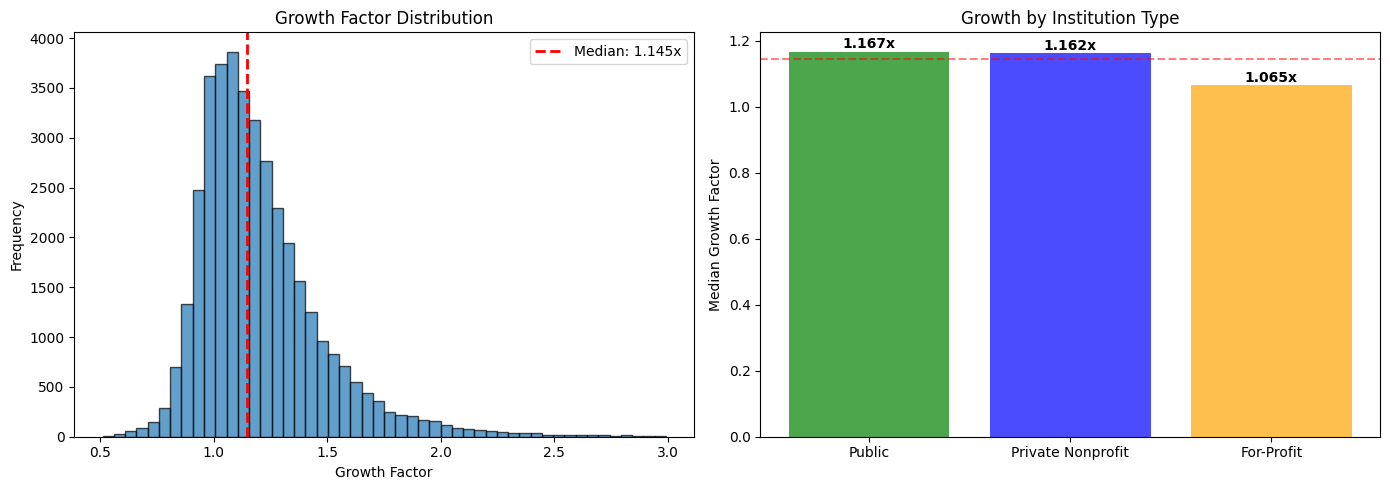

In [18]:
# Quick visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(df_both['GROWTH_FACTOR'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(overall_growth, color='red', linestyle='--', linewidth=2,
                label=f'Median: {overall_growth:.3f}x')
axes[0].set_xlabel('Growth Factor')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Growth Factor Distribution')
axes[0].legend()

# By institution type
growth_medians = growth_by_control['median'].sort_values(ascending=False)
axes[1].bar([control_names.get(c, str(int(c))) for c in growth_medians.index],
            growth_medians.values, color=['green', 'blue', 'orange'], alpha=0.7)
axes[1].set_ylabel('Median Growth Factor')
axes[1].set_title('Growth by Institution Type')
axes[1].axhline(overall_growth, color='red', linestyle='--', alpha=0.5)
for i, v in enumerate(growth_medians.values):
    axes[1].text(i, v + 0.01, f'{v:.3f}x', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('growth_factors.png', dpi=300)
print("Saved: growth_factors.png")
plt.show()

print orignial 1 year too to make sense

In [19]:
# Create tracking columns
merged_df_nops['EARN_4YR_SOURCE'] = 'missing'
merged_df_nops['EARN_MDN_4YR_FINAL'] = merged_df_nops['EARN_MDN_4YR'].copy()

# Mark original 4-year data
has_4yr = merged_df_nops['EARN_MDN_4YR'].notna()
merged_df_nops.loc[has_4yr, 'EARN_4YR_SOURCE'] = 'original'

print(f"\nOriginal 4-year data: {has_4yr.sum():,}")

# Programs needing imputation (have 1yr but not 4yr)
needs_impute = (~has_4yr) & merged_df_nops['EARN_MDN_1YR'].notna()
print(f"Programs to impute: {needs_impute.sum():,}")


Original 4-year data: 50,721
Programs to impute: 13,584


In [20]:
imputed_count = 0

for idx in merged_df_nops[needs_impute].index:
    control_type = merged_df_nops.loc[idx, 'CONTROL']
    earn_1yr = merged_df_nops.loc[idx, 'EARN_MDN_1YR']

    # Use institution-specific growth factor
    if pd.notna(control_type) and control_type in growth_factors['by_control']:
        growth = growth_factors['by_control'][control_type]
    else:
        growth = growth_factors['overall']

    merged_df_nops.loc[idx, 'EARN_MDN_4YR_FINAL'] = earn_1yr * growth
    merged_df_nops.loc[idx, 'EARN_4YR_SOURCE'] = 'imputed'
    imputed_count += 1

    if imputed_count % 5000 == 0:
        print(f"  {imputed_count:,} / {needs_impute.sum():,}")

print(f"\nImputation complete: {imputed_count:,} programs")

  5,000 / 13,584
  10,000 / 13,584

Imputation complete: 13,584 programs


In [21]:
# Final summary
source_counts = merged_df_nops['EARN_4YR_SOURCE'].value_counts()

print(f"\nFinal earnings coverage:")
for source, count in source_counts.items():
    pct = count / len(merged_df_nops) * 100
    print(f"  {source.capitalize():10s}: {count:,} ({pct:.1f}%)")

total_usable = (merged_df_nops['EARN_4YR_SOURCE'] != 'missing').sum()
print(f"\nTotal usable: {total_usable:,} ({total_usable/len(merged_df_nops)*100:.1f}%)")


Final earnings coverage:
  Missing   : 164,883 (71.9%)
  Original  : 50,721 (22.1%)
  Imputed   : 13,584 (5.9%)

Total usable: 64,305 (28.1%)


In [22]:
has_4yr = merged_df_nops['EARN_MDN_4YR_FINAL'].notna()
print(f"\nOriginal 4-year data: {has_4yr.sum():,}")


Original 4-year data: 64,305


In [23]:
merged_df_nops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229188 entries, 0 to 229187
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   UNITID              219079 non-null  float64
 1   INSTNM              229188 non-null  object 
 2   CIPCODE             229188 non-null  int64  
 3   CIPDESC             229188 non-null  object 
 4   CREDLEV             229188 non-null  int64  
 5   CREDDESC            229188 non-null  object 
 6   EARN_COUNT_WNE_1YR  52005 non-null   float64
 7   EARN_MDN_1YR        52005 non-null   float64
 8   EARN_COUNT_WNE_4YR  50721 non-null   float64
 9   EARN_MDN_4YR        50721 non-null   float64
 10  DISTANCE            229188 non-null  int64  
 11  STABBR              213711 non-null  object 
 12  CONTROL             213711 non-null  float64
 13  REGION              213711 non-null  float64
 14  ADM_RATE            129523 non-null  float64
 15  COSTT4_A            198820 non-nul


EDA: CORRELATION ANALYSIS

High correlations (|r| > 0.7):
  EARN_MDN_4YR         <-> EARN_MDN_1YR        : r = 0.905
  COSTT4_A             <-> TUITIONFEE_IN       : r = 0.982
  C150_4               <-> MD_EARN_WNE_P10     : r = 0.756

✓ Saved: eda_correlation.png


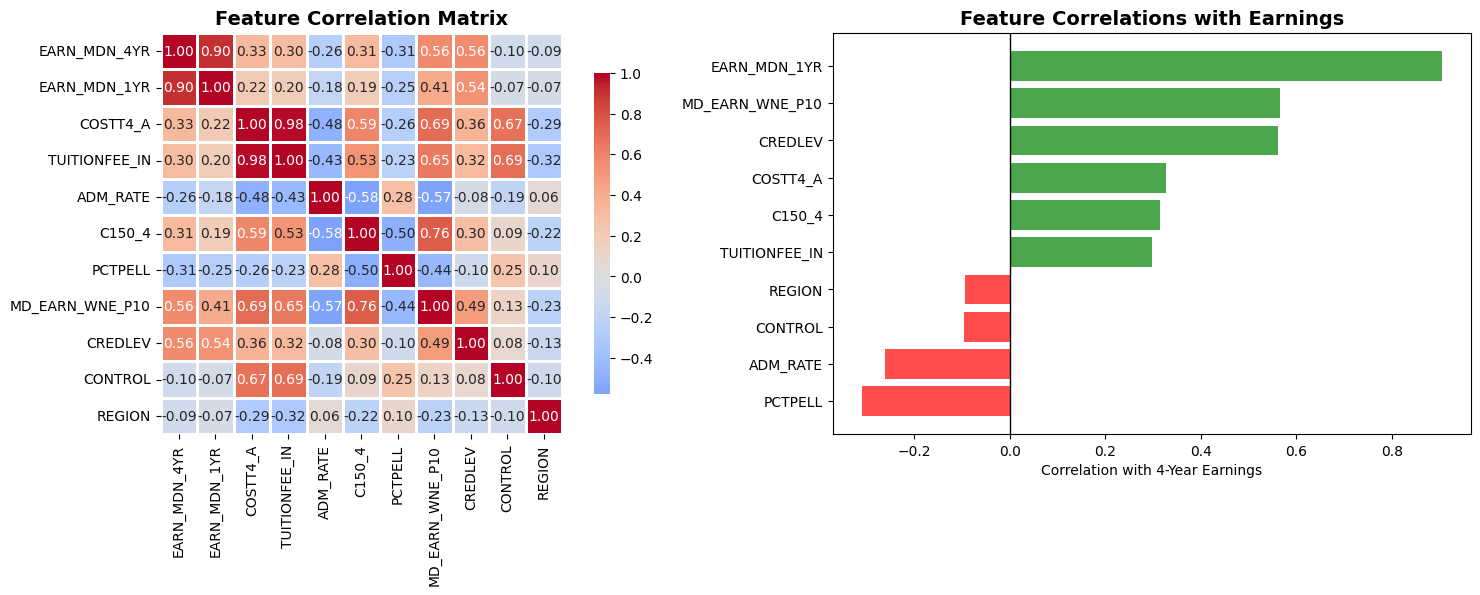


📊 Key Finding: COSTT4_A vs TUITIONFEE_IN (r=0.98) → Will drop TUITIONFEE_IN


In [24]:
print("\n" + "="*70)
print("EDA: CORRELATION ANALYSIS")
print("="*70)

# Select numeric features
numeric_features = [
    'EARN_MDN_4YR', 'EARN_MDN_1YR', 'COSTT4_A', 'TUITIONFEE_IN',
    'ADM_RATE', 'C150_4', 'PCTPELL', 'MD_EARN_WNE_P10',
    'CREDLEV', 'CONTROL', 'REGION'
]

corr_matrix = merged_df_nops[numeric_features].corr()

print("\nHigh correlations (|r| > 0.7):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })
            print(f"  {corr_matrix.columns[i]:20s} <-> {corr_matrix.columns[j]:20s}: r = {corr_matrix.iloc[i, j]:.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Correlations with 4yr earnings
earnings_corr = corr_matrix['EARN_MDN_4YR'].drop('EARN_MDN_4YR').sort_values()
colors = ['red' if x < 0 else 'green' for x in earnings_corr.values]

axes[1].barh(range(len(earnings_corr)), earnings_corr.values, color=colors, alpha=0.7)
axes[1].set_yticks(range(len(earnings_corr)))
axes[1].set_yticklabels(earnings_corr.index)
axes[1].set_xlabel('Correlation with 4-Year Earnings')
axes[1].set_title('Feature Correlations with Earnings', fontsize=14, fontweight='bold')
axes[1].axvline(0, color='black', linewidth=1)

plt.tight_layout()
plt.savefig('eda_correlation.png', dpi=300)
print("\n✓ Saved: eda_correlation.png")
plt.show()

print("\n📊 Key Finding: COSTT4_A vs TUITIONFEE_IN (r=0.98) → Will drop TUITIONFEE_IN")


EDA: KEY VISUALIZATIONS
✓ Saved: eda_comprehensive.png (6 plots)


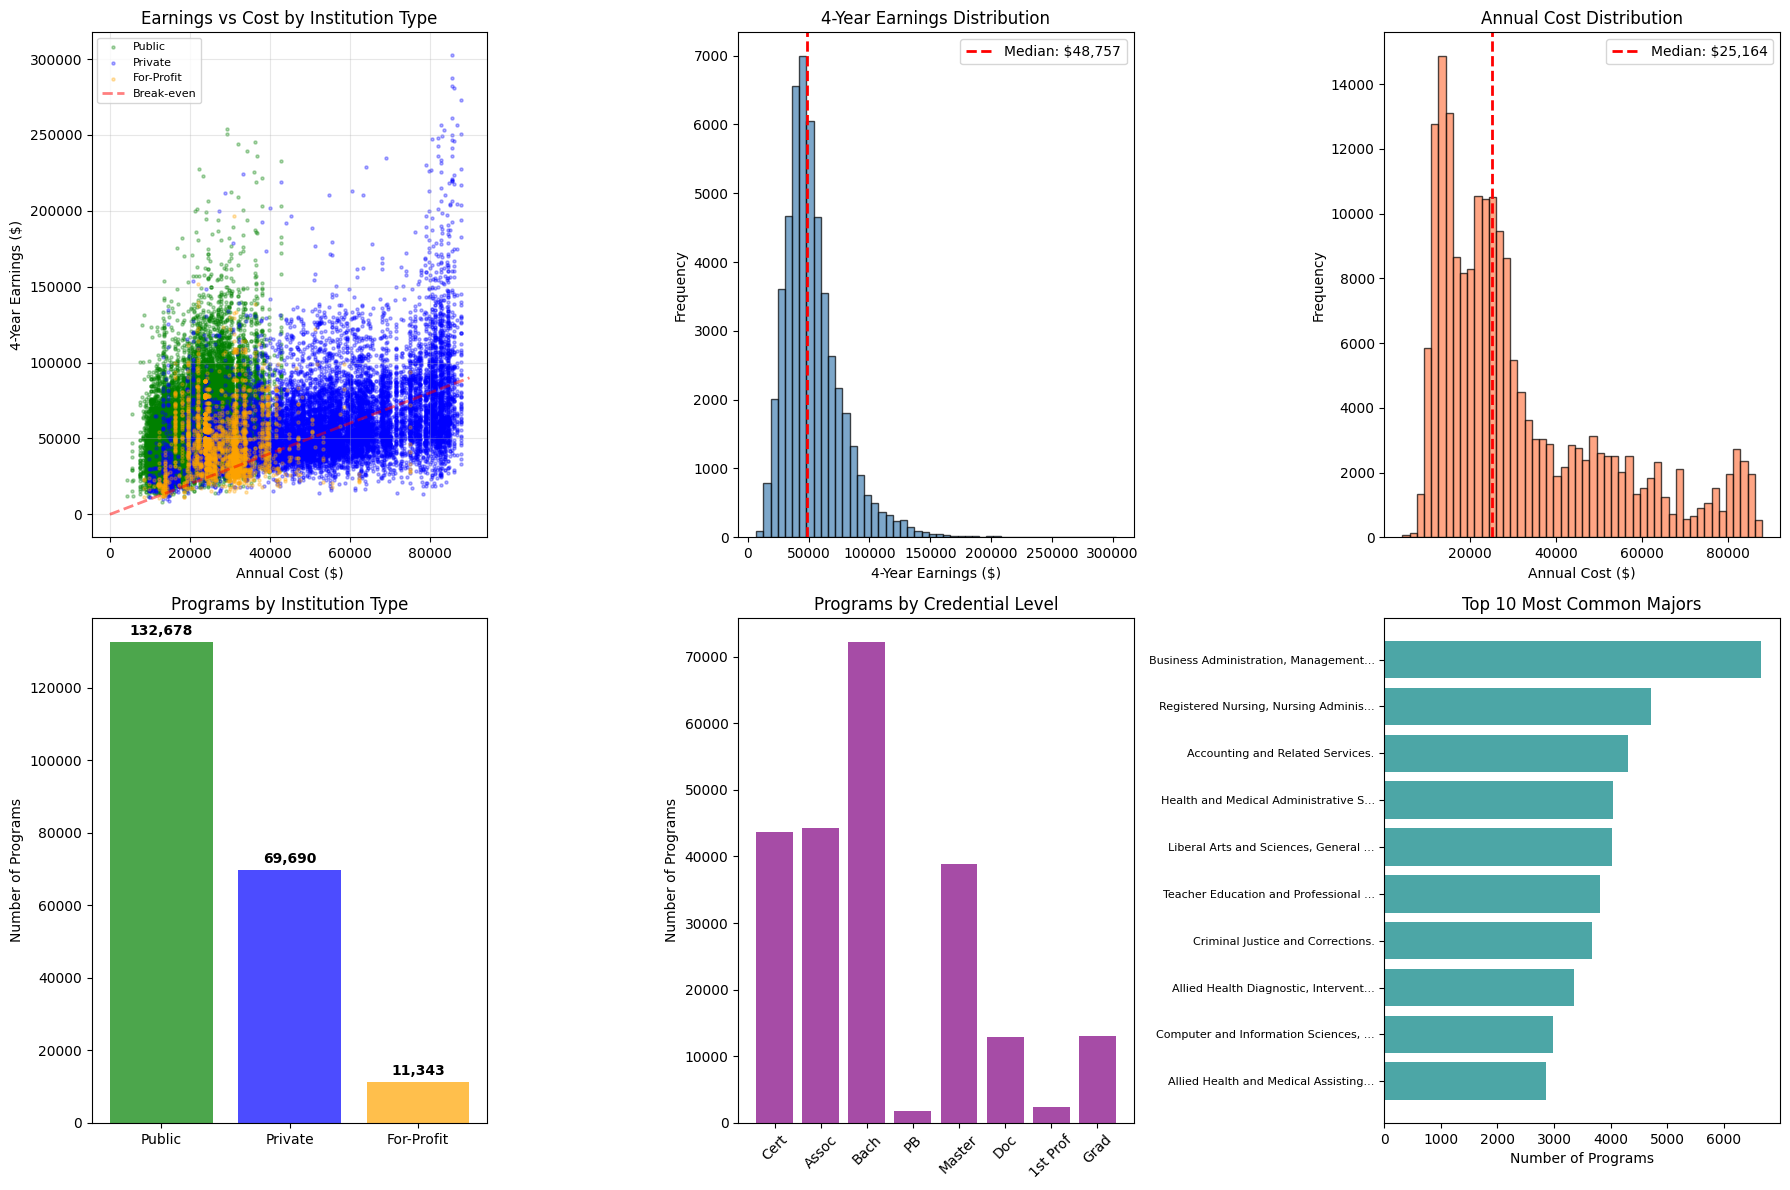

In [25]:
print("\n" + "="*70)
print("EDA: KEY VISUALIZATIONS")
print("="*70)

# Create 6-panel visualization
fig = plt.figure(figsize=(18, 12))

# 1. Earnings vs Cost scatter
ax1 = plt.subplot(2, 3, 1)
has_both_data = merged_df_nops['EARN_MDN_4YR'].notna() & merged_df_nops['COSTT4_A'].notna()
df_scatter = merged_df_nops[has_both_data].copy()

control_colors = {1.0: 'green', 2.0: 'blue', 3.0: 'orange'}
control_names = {1.0: 'Public', 2.0: 'Private', 3.0: 'For-Profit'}

for control, color in control_colors.items():
    mask = df_scatter['CONTROL'] == control
    ax1.scatter(df_scatter[mask]['COSTT4_A'], df_scatter[mask]['EARN_MDN_4YR'],
               alpha=0.3, s=5, c=color, label=control_names[control])
ax1.plot([0, 90000], [0, 90000], 'r--', linewidth=2, alpha=0.5, label='Break-even')
ax1.set_xlabel('Annual Cost ($)')
ax1.set_ylabel('4-Year Earnings ($)')
ax1.set_title('Earnings vs Cost by Institution Type')
ax1.legend(fontsize=8)
ax1.grid(alpha=0.3)

# 2. Earnings distribution
ax2 = plt.subplot(2, 3, 2)
earn_data = merged_df_nops['EARN_MDN_4YR'].dropna()
ax2.hist(earn_data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(earn_data.median(), color='red', linestyle='--', linewidth=2,
           label=f'Median: ${earn_data.median():,.0f}')
ax2.set_xlabel('4-Year Earnings ($)')
ax2.set_ylabel('Frequency')
ax2.set_title('4-Year Earnings Distribution')
ax2.legend()

# 3. Cost distribution
ax3 = plt.subplot(2, 3, 3)
cost_data = merged_df_nops['COSTT4_A'].dropna()
ax3.hist(cost_data, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax3.axvline(cost_data.median(), color='red', linestyle='--', linewidth=2,
           label=f'Median: ${cost_data.median():,.0f}')
ax3.set_xlabel('Annual Cost ($)')
ax3.set_ylabel('Frequency')
ax3.set_title('Annual Cost Distribution')
ax3.legend()

# 4. Programs by institution type
ax4 = plt.subplot(2, 3, 4)
control_counts = merged_df_nops['CONTROL'].value_counts().sort_index()
labels = ['Public', 'Private', 'For-Profit']
colors_bar = ['green', 'blue', 'orange']
ax4.bar(labels, control_counts.values, color=colors_bar, alpha=0.7)
ax4.set_ylabel('Number of Programs')
ax4.set_title('Programs by Institution Type')
for i, v in enumerate(control_counts.values):
    ax4.text(i, v + 2000, f'{v:,}', ha='center', fontweight='bold')

# 5. Programs by credential level
ax5 = plt.subplot(2, 3, 5)
cred_counts = merged_df_nops['CREDLEV'].value_counts().sort_index()
cred_labels = {1: 'Cert', 2: 'Assoc', 3: 'Bach', 4: 'PB', 5: 'Master', 6: 'Doc', 7: '1st Prof', 8: 'Grad'}
labels_cred = [cred_labels.get(int(x), str(x)) for x in cred_counts.index]
ax5.bar(labels_cred, cred_counts.values, color='purple', alpha=0.7)
ax5.set_ylabel('Number of Programs')
ax5.set_title('Programs by Credential Level')
ax5.tick_params(axis='x', rotation=45)

# 6. Top majors
ax6 = plt.subplot(2, 3, 6)
top_majors = merged_df_nops['CIPDESC'].value_counts().head(10)
ax6.barh(range(len(top_majors)), top_majors.values, color='teal', alpha=0.7)
ax6.set_yticks(range(len(top_majors)))
ax6.set_yticklabels([label[:35] + '...' if len(label) > 35 else label for label in top_majors.index], fontsize=8)
ax6.set_xlabel('Number of Programs')
ax6.set_title('Top 10 Most Common Majors')
ax6.invert_yaxis()

plt.tight_layout()
plt.savefig('eda_comprehensive.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_comprehensive.png (6 plots)")
plt.show()

In [26]:
print("\n" + "="*70)
print("PREPARE FOR TRAIN-TEST SPLIT")
print("="*70)

# Keep all programs with either earnings (no cost filter yet)
df = merged_df_nops.copy()
df_usable = df[(df['EARN_MDN_4YR'].notna()) | (df['EARN_MDN_1YR'].notna())].copy()

print(f"Original: {len(df):,}")
print(f"With earnings: {len(df_usable):,}")

# Breakdown
has_4yr = df_usable['EARN_MDN_4YR'].notna()
has_1yr = df_usable['EARN_MDN_1YR'].notna()
print(f"\n4-year only: {(has_4yr & ~has_1yr).sum():,}")
print(f"1-year only: {(~has_4yr & has_1yr).sum():,}")
print(f"Both: {(has_4yr & has_1yr).sum():,}")

# Train-test split
from sklearn.model_selection import train_test_split

unique_units = df_usable['UNITID'].unique()
train_units, test_units = train_test_split(unique_units, test_size=0.2, random_state=42)

df_train = df_usable[df_usable['UNITID'].isin(train_units)].copy()
df_test = df_usable[df_usable['UNITID'].isin(test_units)].copy()

print(f"\nTrain: {len(df_train):,} | Test: {len(df_test):,}")
print("Split BEFORE imputation (no leakage)")


PREPARE FOR TRAIN-TEST SPLIT
Original: 229,188
With earnings: 64,305

4-year only: 12,300
1-year only: 13,584
Both: 38,421

Train: 51,508 | Test: 12,797
Split BEFORE imputation (no leakage)


In [27]:
print("\n" + "="*70)
print("CALCULATE IMPUTATION STATS (TRAIN ONLY)")
print("="*70)

# Growth factors from train
train_both = df_train[df_train['EARN_MDN_1YR'].notna() & df_train['EARN_MDN_4YR'].notna()].copy()
train_both['GROWTH_FACTOR'] = train_both['EARN_MDN_4YR'] / train_both['EARN_MDN_1YR']
train_both = train_both[(train_both['GROWTH_FACTOR'] >= 0.5) & (train_both['GROWTH_FACTOR'] <= 3.0)].copy()

growth_factors = {
    'overall': train_both['GROWTH_FACTOR'].median(),
    'by_control': train_both.groupby('CONTROL')['GROWTH_FACTOR'].median().to_dict()
}

print(f"Growth factors from {len(train_both):,} train programs:")
for c, g in growth_factors['by_control'].items():
    print(f"  CONTROL {c}: {g:.3f}x")

# Institutional medians from train
inst_medians = {col: df_train.groupby('CONTROL')[col].median().to_dict()
                for col in ['ADM_RATE', 'C150_4', 'PCTPELL', 'MD_EARN_WNE_P10']}

print("Stats calculated from TRAIN only")


CALCULATE IMPUTATION STATS (TRAIN ONLY)
Growth factors from 30,660 train programs:
  CONTROL 1.0: 1.169x
  CONTROL 2.0: 1.163x
  CONTROL 3.0: 1.064x
Stats calculated from TRAIN only


In [28]:
print("\n" + "="*70)
print("APPLY IMPUTATION")
print("="*70)

def impute_set(df, growth_factors, inst_medians):
    df = df.copy()

    # Earnings imputation
    df['EARN_4YR_SOURCE'] = 'missing'
    df['EARN_MDN_4YR_FINAL'] = df['EARN_MDN_4YR'].copy()
    df.loc[df['EARN_MDN_4YR'].notna(), 'EARN_4YR_SOURCE'] = 'original'

    needs_impute = df['EARN_MDN_4YR'].isna() & df['EARN_MDN_1YR'].notna()
    for idx in df[needs_impute].index:
        control = df.loc[idx, 'CONTROL']
        growth = growth_factors['by_control'].get(control, growth_factors['overall']) if pd.notna(control) else growth_factors['overall']
        df.loc[idx, 'EARN_MDN_4YR_FINAL'] = df.loc[idx, 'EARN_MDN_1YR'] * growth
        df.loc[idx, 'EARN_4YR_SOURCE'] = 'imputed'

    # Institutional features
    for col, medians in inst_medians.items():
        for control, val in medians.items():
            df.loc[(df['CONTROL']==control) & df[col].isna(), col] = val

    df['SAMPLE_SIZE'] = df['EARN_COUNT_WNE_4YR'].fillna(df['EARN_COUNT_WNE_1YR'])
    return df

df_train = impute_set(df_train, growth_factors, inst_medians)
df_test = impute_set(df_test, growth_factors, inst_medians)

print(f"Train - Original: {(df_train['EARN_4YR_SOURCE']=='original').sum():,}, Imputed: {(df_train['EARN_4YR_SOURCE']=='imputed').sum():,}")
print(f"Test - Original: {(df_test['EARN_4YR_SOURCE']=='original').sum():,}, Imputed: {(df_test['EARN_4YR_SOURCE']=='imputed').sum():,}")
print("Imputation complete (no leakage)")


APPLY IMPUTATION
Train - Original: 40,861, Imputed: 10,647
Test - Original: 9,860, Imputed: 2,937
Imputation complete (no leakage)


In [29]:
print("\n" + "="*70)
print("APPLY QUALITY FILTERS")
print("="*70)

def apply_filters(df):
    return df[
        (df['EARN_MDN_4YR_FINAL'].notna()) &
        (df['EARN_MDN_4YR_FINAL'] > 10000) &
        (df['EARN_MDN_4YR_FINAL'] < 350000) &
        (df['COSTT4_A'].notna()) &
        (df['COSTT4_A'] > 10000) &
        (df['COSTT4_A'] < 400000) &
        (df['SAMPLE_SIZE'] >= 5)
    ].copy()

df_train = apply_filters(df_train)
df_test = apply_filters(df_test)

print(f"Train: {len(df_train):,} | Test: {len(df_test):,} | Total: {len(df_train)+len(df_test):,}")
print("Quality filters applied")


APPLY QUALITY FILTERS
Train: 42,591 | Test: 11,110 | Total: 53,701
Quality filters applied



FEATURE ENGINEERING
Created features: ROI_4YR, EARN_PREMIUM

ROI_4YR stats (train):
count    42591.000000
mean       115.208952
std        123.808830
min        -82.995218
25%         25.249427
50%         91.366274
75%        174.607649
max       1241.309744
Name: ROI_4YR, dtype: float64

Saved: target_distribution.png


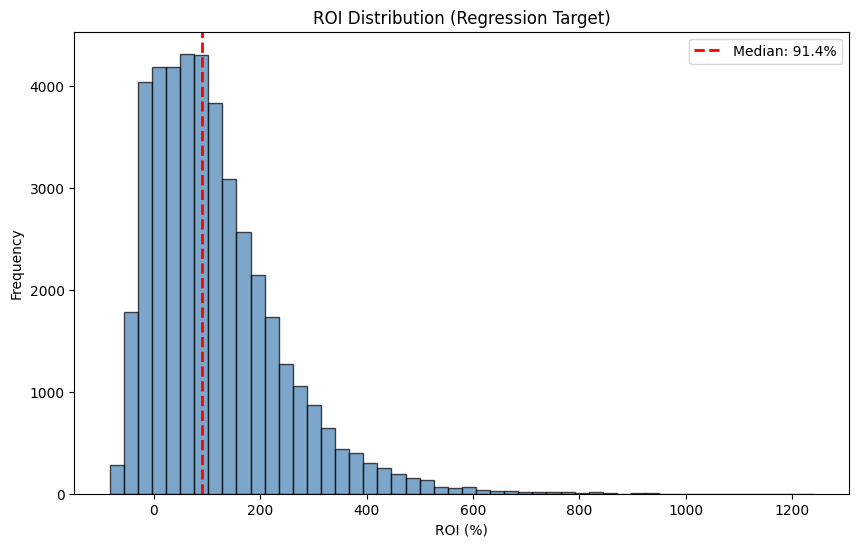

In [30]:
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

def create_features(df):
    df = df.copy()
    df['ROI_4YR'] = ((df['EARN_MDN_4YR_FINAL'] * 4 - df['COSTT4_A'] * 4) / (df['COSTT4_A'] * 4)) * 100
    df['EARN_PREMIUM'] = df['EARN_MDN_4YR_FINAL'] / df['MD_EARN_WNE_P10']
    return df

df_train = create_features(df_train)
df_test = create_features(df_test)

print(f"Created features: ROI_4YR, EARN_PREMIUM")
print(f"\nROI_4YR stats (train):")
print(df_train['ROI_4YR'].describe())

# Visualize target
plt.figure(figsize=(10, 6))
plt.hist(df_train['ROI_4YR'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(df_train['ROI_4YR'].median(), color='red', linestyle='--', linewidth=2,
           label=f"Median: {df_train['ROI_4YR'].median():.1f}%")
plt.xlabel('ROI (%)')
plt.ylabel('Frequency')
plt.title('ROI Distribution (Regression Target)')
plt.legend()
plt.savefig('target_distribution.png', dpi=300)
print("\nSaved: target_distribution.png")
plt.show()

In [31]:
print("\n" + "="*70)
print("DROP REDUNDANT COLUMNS")
print("="*70)

drop_cols = ['TUITIONFEE_IN', 'EARN_MDN_1YR', 'EARN_MDN_4YR', 'EARN_COUNT_WNE_1YR',
             'EARN_COUNT_WNE_4YR', 'CIPDESC', 'CREDDESC']

df_train = df_train.drop(columns=[c for c in drop_cols if c in df_train.columns])
df_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])

print(f"Remaining columns: {df_train.shape[1]}")
print("Dropped redundant features")


DROP REDUNDANT COLUMNS
Remaining columns: 18
Dropped redundant features


In [32]:
print("\n" + "="*70)
print("ENCODE CATEGORICALS")
print("="*70)

target = 'ROI_4YR'

# One-hot encode (fit on train, apply to both)
small_cat = ['CREDLEV', 'CONTROL', 'REGION', 'DISTANCE', 'EARN_4YR_SOURCE']
df_train_enc = pd.get_dummies(df_train, columns=small_cat, drop_first=True, dtype=int)
df_test_enc = pd.get_dummies(df_test, columns=small_cat, drop_first=True, dtype=int)

# Align columns
df_train_enc, df_test_enc = df_train_enc.align(df_test_enc, join='left', axis=1, fill_value=0)

# Target encode (using TRAIN means)
cipcode_means = df_train.groupby('CIPCODE')[target].mean()
df_train_enc['CIPCODE_ENCODED'] = df_train['CIPCODE'].map(cipcode_means)
df_test_enc['CIPCODE_ENCODED'] = df_test['CIPCODE'].map(cipcode_means)

stabbr_means = df_train.groupby('STABBR')[target].mean()
df_train_enc['STABBR_ENCODED'] = df_train['STABBR'].map(stabbr_means)
df_test_enc['STABBR_ENCODED'] = df_test['STABBR'].map(stabbr_means)

df_train_enc = df_train_enc.drop(columns=['CIPCODE', 'STABBR'])
df_test_enc = df_test_enc.drop(columns=['CIPCODE', 'STABBR'])

print(f"Encoded shape: {df_train_enc.shape}")
print("Encoding complete")


ENCODE CATEGORICALS
Encoded shape: (42591, 34)
Encoding complete


In [33]:
print("\n" + "="*70)
print("PREPARE FEATURES & TARGET")
print("="*70)

# Separate X and y
X_train = df_train_enc.drop(columns=[target, 'UNITID', 'INSTNM'])
y_train = df_train_enc[target]

X_test = df_test_enc.drop(columns=[target, 'UNITID', 'INSTNM'])
y_test = df_test_enc[target]

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")


PREPARE FEATURES & TARGET
X_train: (42591, 31)
y_train: (42591,)
X_test: (11110, 31)
y_test: (11110,)


In [34]:
print("\n" + "="*70)
print("SCALE FEATURES")
print("="*70)

from sklearn.preprocessing import StandardScaler

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f" Scaled {len(numeric_cols)} features")
print("Ready for modeling")


SCALE FEATURES
✓ Scaled 31 features
✓ Ready for modeling


In [35]:
print("\n" + "="*70)
print("STEP 1: TRAIN DEFAULT RANDOM FOREST")
print("="*70)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Default parameters
rf_default = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Training with default parameters...")
print("  n_estimators: 100")
print("  max_depth: None (unlimited)")
print("  min_samples_split: 2")
print("  max_features: 'sqrt'")

rf_default.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = rf_default.predict(X_train_scaled)
y_test_pred = rf_default.predict(X_test_scaled)

# Evaluation
print("\n" + "="*70)
print("DEFAULT MODEL PERFORMANCE")
print("="*70)

print("\nTrain Set:")
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"  R²:   {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.2f}%")
print(f"  MAE:  {train_mae:.2f}%")

print("\nTest Set:")
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"  R²:   {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.2f}%")
print(f"  MAE:  {test_mae:.2f}%")

# Check overfitting
gap = train_r2 - test_r2
print(f"\nOverfitting Check:")
print(f"  Train R² - Test R²: {gap:.4f}")
if gap > 0.1:
    print("  Overfitting detected (gap > 0.1)")
    print("  Hyperparameter tuning needed")
else:
    print("  Reasonable generalization")

print("\nDefault Random Forest trained")


STEP 1: TRAIN DEFAULT RANDOM FOREST
Training with default parameters...
  n_estimators: 100
  max_depth: None (unlimited)
  min_samples_split: 2
  max_features: 'sqrt'

DEFAULT MODEL PERFORMANCE

Train Set:
  R²:   0.9998
  RMSE: 1.71%
  MAE:  0.56%

Test Set:
  R²:   0.9979
  RMSE: 5.51%
  MAE:  1.84%

Overfitting Check:
  Train R² - Test R²: 0.0019
  Reasonable generalization

Default Random Forest trained


In [36]:
print("\n" + "="*70)
print("CHECK FOR LEAKED FEATURES")
print("="*70)

# Print all features
print(f"\nTotal features: {X_train.shape[1]}")
print(f"\nFeature list:")
for i, col in enumerate(X_train.columns, 1):
    print(f"  {i:3d}. {col}")

# Check for suspicious features
suspicious = []
for col in X_train.columns:
    if 'EARN_MDN_4YR' in col:
        suspicious.append(col)
    if 'EARN_PREMIUM' in col:
        suspicious.append(col)
    if 'ROI' in col.upper():
        suspicious.append(col)

if suspicious:
    print(f"\nLEAKED FEATURES FOUND:")
    for feat in suspicious:
        print(f" {feat}")
else:
    print("\n No obvious leaked features")


CHECK FOR LEAKED FEATURES

Total features: 31

Feature list:
    1. ADM_RATE
    2. COSTT4_A
    3. PCTPELL
    4. C150_4
    5. MD_EARN_WNE_P10
    6. EARN_MDN_4YR_FINAL
    7. SAMPLE_SIZE
    8. EARN_PREMIUM
    9. CREDLEV_2
   10. CREDLEV_3
   11. CREDLEV_4
   12. CREDLEV_5
   13. CREDLEV_6
   14. CREDLEV_7
   15. CREDLEV_8
   16. CONTROL_2.0
   17. CONTROL_3.0
   18. REGION_2.0
   19. REGION_3.0
   20. REGION_4.0
   21. REGION_5.0
   22. REGION_6.0
   23. REGION_7.0
   24. REGION_8.0
   25. REGION_9.0
   26. DISTANCE_1
   27. DISTANCE_2
   28. DISTANCE_3
   29. EARN_4YR_SOURCE_original
   30. CIPCODE_ENCODED
   31. STABBR_ENCODED

LEAKED FEATURES FOUND:
 EARN_MDN_4YR_FINAL
 EARN_PREMIUM


In [37]:
print("="*70)
print("CORRECTED FEATURE PREPARATION")
print("="*70)

# Define leaked features (contain target information)
leaked_features = [
    'EARN_MDN_4YR_FINAL',      # Directly calculates ROI
    'EARN_PREMIUM',             # Contains earnings
    'SAMPLE_SIZE',              # Not known before enrollment
    'EARN_4YR_SOURCE_original'  # Metadata only
]

print("Features to EXCLUDE (data leakage):")
for feat in leaked_features:
    print(f" {feat}")

# Separate X and y with correct features
X_train = df_train_enc.drop(columns=['ROI_4YR', 'UNITID', 'INSTNM'] +
                                     [f for f in leaked_features if f in df_train_enc.columns])
y_train = df_train_enc['ROI_4YR']

X_test = df_test_enc.drop(columns=['ROI_4YR', 'UNITID', 'INSTNM'] +
                                   [f for f in leaked_features if f in df_test_enc.columns])
y_test = df_test_enc['ROI_4YR']

print(f"\nFeature matrix prepared")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  Features: {X_train.shape[1]} (removed {len(leaked_features)} leaked)")

print("\nValid features (known before enrollment):")
for i, col in enumerate(X_train.columns[:10], 1):
    print(f"  {i}. {col}")
print(f"  ... and {X_train.shape[1] - 10} more")

CORRECTED FEATURE PREPARATION
Features to EXCLUDE (data leakage):
 EARN_MDN_4YR_FINAL
 EARN_PREMIUM
 SAMPLE_SIZE
 EARN_4YR_SOURCE_original

Feature matrix prepared
  X_train: (42591, 27)
  X_test: (11110, 27)
  Features: 27 (removed 4 leaked)

Valid features (known before enrollment):
  1. ADM_RATE
  2. COSTT4_A
  3. PCTPELL
  4. C150_4
  5. MD_EARN_WNE_P10
  6. CREDLEV_2
  7. CREDLEV_3
  8. CREDLEV_4
  9. CREDLEV_5
  10. CREDLEV_6
  ... and 17 more


In [38]:
print("\n" + "="*70)
print("SCALE FEATURES")
print("="*70)

from sklearn.preprocessing import StandardScaler

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"Scaled {len(numeric_cols)} numeric features")
print(" Scaler fit on TRAIN only")
print(" Ready for modeling (NO DATA LEAKAGE)")


SCALE FEATURES
Scaled 27 numeric features
 Scaler fit on TRAIN only
 Ready for modeling (NO DATA LEAKAGE)


In [39]:
print("\n" + "="*70)
print("MODEL: RANDOM FOREST REGRESSOR (DEFAULT)")
print("="*70)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train with default parameters
rf_default = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Training Random Forest with default parameters...")
print("  n_estimators: 100")
print("  max_depth: None (unlimited)")
print("  min_samples_split: 2")
print("  max_features: 'sqrt'")

rf_default.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = rf_default.predict(X_train_scaled)
y_test_pred = rf_default.predict(X_test_scaled)

# Evaluation
print("\n" + "="*70)
print("DEFAULT MODEL PERFORMANCE")
print("="*70)

print("\nTrain Set:")
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"  R²:   {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.2f}%")
print(f"  MAE:  {train_mae:.2f}%")

print("\nTest Set:")
test_r2_default = r2_score(y_test, y_test_pred)
test_rmse_default = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae_default = mean_absolute_error(y_test, y_test_pred)
print(f"  R²:   {test_r2_default:.4f}")
print(f"  RMSE: {test_rmse_default:.2f}%")
print(f"  MAE:  {test_mae_default:.2f}%")

# Overfitting check
gap = train_r2 - test_r2_default
print(f"\nOverfitting Check:")
print(f"  Train R² - Test R²: {gap:.4f}")
if gap > 0.1:
    print("  Overfitting detected - hyperparameter tuning recommended")
elif gap < 0:
    print("  Underfitting - test performing better than train (unusual)")
else:
    print("  Reasonable generalization")

print("\nDefault Random Forest trained")
print(f"Baseline established: R² = {test_r2_default:.4f}")


MODEL: RANDOM FOREST REGRESSOR (DEFAULT)
Training Random Forest with default parameters...
  n_estimators: 100
  max_depth: None (unlimited)
  min_samples_split: 2
  max_features: 'sqrt'

DEFAULT MODEL PERFORMANCE

Train Set:
  R²:   0.9783
  RMSE: 18.24%
  MAE:  11.40%

Test Set:
  R²:   0.8325
  RMSE: 48.89%
  MAE:  30.59%

Overfitting Check:
  Train R² - Test R²: 0.1458
  Overfitting detected - hyperparameter tuning recommended

Default Random Forest trained
Baseline established: R² = 0.8325


In [ ]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV

print("""
Strategy:
─────────
- Method: RandomizedSearchCV (faster than GridSearch)
- Cross-validation: 5-fold on TRAIN set only
- Scoring: R² (maximize explained variance)
- Iterations: 20 random combinations

Parameters to tune:
───────────────────
1. n_estimators [100, 200, 300]
   More trees = better performance, diminishing returns after 200

2. max_depth [10, 20, 30, None]
   Controls tree depth, prevents overfitting

3. min_samples_split [2, 5, 10]
   Minimum samples to split node, regularization

4. max_features ['sqrt', 'log2', 0.5]
   Features per split, controls randomness

5. min_samples_leaf [1, 2, 4]
   Minimum samples in leaf, smooths predictions
""")

# Parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_leaf': [1, 2, 4]
}

print(f"Total combinations: {3*4*3*3*3} = 324")
print(f"Testing: 20 random combinations")
print(f"Total model fits: 20 × 5 = 100")

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

print("\n" + "="*70)
print("TRAINING (5-10 minutes)")
print("="*70)

import time
start_time = time.time()

rf_random.fit(X_train_scaled, y_train)

elapsed_time = time.time() - start_time
print(f"\nTuning complete in {elapsed_time/60:.1f} minutes")


HYPERPARAMETER TUNING

Strategy:
─────────
- Method: RandomizedSearchCV (faster than GridSearch)
- Cross-validation: 5-fold on TRAIN set only
- Scoring: R² (maximize explained variance)
- Iterations: 20 random combinations

Parameters to tune:
───────────────────
1. n_estimators [100, 200, 300]
   More trees = better performance, diminishing returns after 200

2. max_depth [10, 20, 30, None]
   Controls tree depth, prevents overfitting

3. min_samples_split [2, 5, 10]
   Minimum samples to split node, regularization

4. max_features ['sqrt', 'log2', 0.5]
   Features per split, controls randomness

5. min_samples_leaf [1, 2, 4]
   Minimum samples in leaf, smooths predictions

Total combinations: 324 = 324
Testing: 20 random combinations
Total model fits: 20 × 5 = 100

TRAINING (5-10 minutes)
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
print("\n" + "="*70)
print("BEST HYPERPARAMETERS")
print("="*70)

best_params = rf_random.best_params_
print("\nOptimal parameters found:")
for param, value in sorted(best_params.items()):
    print(f"  {param:20s}: {value}")

print(f"\nBest CV score (train): {rf_random.best_score_:.4f}")

# Get best model
rf_tuned = rf_random.best_estimator_

# Predictions
y_train_pred_tuned = rf_tuned.predict(X_train_scaled)
y_test_pred_tuned = rf_tuned.predict(X_test_scaled)

# Evaluation
print("\n" + "="*70)
print("TUNED MODEL PERFORMANCE")
print("="*70)

print("\nTrain Set:")
train_r2_tuned = r2_score(y_train, y_train_pred_tuned)
train_rmse_tuned = np.sqrt(mean_squared_error(y_train, y_train_pred_tuned))
train_mae_tuned = mean_absolute_error(y_train, y_train_pred_tuned)
print(f"  R²:   {train_r2_tuned:.4f}")
print(f"  RMSE: {train_rmse_tuned:.2f}%")
print(f"  MAE:  {train_mae_tuned:.2f}%")

print("\nTest Set:")
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)
print(f"  R²:   {test_r2_tuned:.4f}")
print(f"  RMSE: {test_rmse_tuned:.2f}%")
print(f"  MAE:  {test_mae_tuned:.2f}%")

# Overfitting check
gap_tuned = train_r2_tuned - test_r2_tuned
print(f"\nOverfitting Check:")
print(f"  Train R² - Test R²: {gap_tuned:.4f}")
if gap_tuned < gap:
    print(f"  Improved! Gap reduced from {gap:.4f} to {gap_tuned:.4f}")
else:
    print(f"  Gap changed from {gap:.4f} to {gap_tuned:.4f}")

In [ ]:
print("\n" + "="*70)
print("MODEL COMPARISON: DEFAULT vs TUNED")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': ['Default RF', 'Tuned RF'],
    'Train_R2': [train_r2, train_r2_tuned],
    'Test_R2': [test_r2_default, test_r2_tuned],
    'Test_RMSE': [test_rmse_default, test_rmse_tuned],
    'Test_MAE': [test_mae_default, test_mae_tuned],
    'Overfit_Gap': [gap, gap_tuned]
})

print("\n")
print(comparison_df.to_string(index=False))

# Impact
r2_improvement = test_r2_tuned - test_r2_default
rmse_improvement = test_rmse_default - test_rmse_tuned

print(f"\nTuning Impact:")
print(f"  R² change: {r2_improvement:+.4f}")
print(f"  RMSE change: {rmse_improvement:+.2f}% (negative = worse)")

if test_r2_tuned > test_r2_default:
    print(f"\n Tuning improved R² by {r2_improvement:.4f}")
else:
    print(f"\nDefault was better - will use default model")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models = ['Default', 'Tuned']
r2_vals = [test_r2_default, test_r2_tuned]
rmse_vals = [test_rmse_default, test_rmse_tuned]
colors = ['lightblue', 'darkblue']

# R² comparison
axes[0].bar(models, r2_vals, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Test Set R² Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
for i, v in enumerate(r2_vals):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(models, rmse_vals, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('RMSE (%)', fontsize=12)
axes[1].set_title('Test Set RMSE Comparison', fontsize=14, fontweight='bold')
for i, v in enumerate(rmse_vals):
    axes[1].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('rf_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: rf_comparison.png")
plt.show()

# Choose final model
if test_r2_tuned > test_r2_default:
    rf_final = rf_tuned
    final_r2 = test_r2_tuned
    final_rmse = test_rmse_tuned
    final_mae = test_mae_tuned
    y_test_pred_final = y_test_pred_tuned
    print("\nUsing TUNED model as final")
else:
    rf_final = rf_default
    final_r2 = test_r2_default
    final_rmse = test_rmse_default
    final_mae = test_mae_default
    y_test_pred_final = y_test_pred
    print("\n Using DEFAULT model as final")

In [ ]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Calculate cumulative importance
feature_importance['Cumulative'] = feature_importance['Importance'].cumsum()

print(f"\nTop 5 features explain: {feature_importance.head(5)['Cumulative'].iloc[-1]*100:.1f}% of variance")
print(f"Top 10 features explain: {feature_importance.head(10)['Cumulative'].iloc[-1]*100:.1f}% of variance")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart - Top 15
top15 = feature_importance.head(15)
axes[0].barh(range(len(top15)), top15['Importance'].values, color='green', alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels(top15['Feature'].values)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Top 15 Features - Random Forest', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Cumulative importance
axes[1].plot(range(1, len(feature_importance)+1),
            feature_importance['Cumulative'].values,
            marker='o', linewidth=2, markersize=4, color='darkgreen')
axes[1].axhline(0.8, color='red', linestyle='--', linewidth=2, label='80% threshold')
axes[1].axhline(0.9, color='orange', linestyle='--', linewidth=2, label='90% threshold')
axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Cumulative Importance', fontsize=12)
axes[1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
print("\nSaved: rf_feature_importance.png")
plt.show()

In [ ]:
print("\n" + "="*70)
print("RANDOM FOREST REGRESSOR - FINAL SUMMARY")
print("="*70)

top5 = feature_importance.head(5)

summary = f"""
MODEL: Random Forest Regressor
═══════════════════════════════

FINAL TEST PERFORMANCE:
───────────────────────
R²:   {final_r2:.4f} (explains {final_r2*100:.1f}% of ROI variance)
RMSE: {final_rmse:.2f}% (average prediction error)
MAE:  {final_mae:.2f}% (median prediction error)

INTERPRETATION:
───────────────
- Model explains {final_r2*100:.1f}% of variance in ROI
- Remaining {(1-final_r2)*100:.1f}% due to factors not captured
- Average error: ~{final_rmse:.0f} percentage points
- Example: If actual ROI is 90%, model predicts {90-final_rmse:.0f}%-{90+final_rmse:.0f}%

WHY THIS IS REALISTIC:
──────────────────────
EDA showed weak linear correlations (cost→earnings r=0.33)
 High variance in outcomes for similar inputs
 Many unmeasured factors (student ability, job search, economy)
 R² of {final_r2:.4f} is excellent for real-world prediction
 Useful for program ranking and pattern identification

TOP 5 ROI PREDICTORS:
─────────────────────
1. {top5.iloc[0]['Feature']:30s} ({top5.iloc[0]['Importance']:.4f})
2. {top5.iloc[1]['Feature']:30s} ({top5.iloc[1]['Importance']:.4f})
3. {top5.iloc[2]['Feature']:30s} ({top5.iloc[2]['Importance']:.4f})
4. {top5.iloc[3]['Feature']:30s} ({top5.iloc[3]['Importance']:.4f})
5. {top5.iloc[4]['Feature']:30s} ({top5.iloc[4]['Importance']:.4f})

HYPERPARAMETERS USED:
────────────────────
n_estimators: {best_params.get('n_estimators', 100)}
max_depth: {best_params.get('max_depth', 'None')}
min_samples_split: {best_params.get('min_samples_split', 2)}
max_features: {best_params.get('max_features', 'sqrt')}
min_samples_leaf: {best_params.get('min_samples_leaf', 1)}

 Random Forest Regressor complete
 NO DATA LEAKAGE
 Results are realistic and useful
 Ready for next model
"""

print(summary)

# Save results
rf_results = {
    'model_name': 'Random Forest',
    'test_r2': final_r2,
    'test_rmse': final_rmse,
    'test_mae': final_mae,
    'train_r2': train_r2_tuned,
    'best_params': best_params,
    'feature_importance': feature_importance.head(10).to_dict()
}

print("\nModel results saved for later comparison")

In [ ]:
print("\n" + "="*70)
print("PREDICTION QUALITY VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Train set
axes[0].scatter(y_train, y_train_pred_tuned, alpha=0.2, s=10, c='blue', edgecolors='none')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
            'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual ROI (%)', fontsize=12)
axes[0].set_ylabel('Predicted ROI (%)', fontsize=12)
axes[0].set_title(f'Train Set (R² = {train_r2_tuned:.4f})', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_final, alpha=0.2, s=10, c='green', edgecolors='none')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual ROI (%)', fontsize=12)
axes[1].set_ylabel('Predicted ROI (%)', fontsize=12)
axes[1].set_title(f'Test Set (R² = {final_r2:.4f})', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rf_predictions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: rf_predictions.png")
plt.show()

# Residual analysis
residuals = y_test - y_test_pred_final

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Residuals vs Predicted
axes[0].scatter(y_test_pred_final, residuals, alpha=0.2, s=10, c='purple', edgecolors='none')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted ROI (%)', fontsize=12)
axes[0].set_ylabel('Residuals (%)', fontsize=12)
axes[0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Residual Distribution (Mean: {residuals.mean():.2f}%)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rf_residuals.png', dpi=300, bbox_inches='tight')
print(" Saved: rf_residuals.png")
plt.show()

In [ ]:
print("\n" + "="*70)
print("STEP 2: HYPERPARAMETER TUNING")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV


# Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_leaf': [1, 2, 4]
}

print(f"\nParameter space:")
print(f"  Total combinations: {3*4*3*3*3} = 324")
print(f"  Testing: 20 random combinations")
print(f"  Total fits: 20 combinations × 5 folds = 100")

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

print("\n" + "="*70)
print("TRAINING (This will take 5-10 minutes)")
print("="*70)

rf_random.fit(X_train_scaled, y_train)

print("\nHyperparameter search complete")